In [29]:
import numpy as np
import scipy as sp
import cvxpy as cp

from models import VFL
from methods import algorithm_1, TrackingADMM, DPMM

from typing import List

from tqdm import tqdm
from matplotlib import pyplot as plt

myparams = {
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}',
    'font.family': 'Djvu Serif',
    'font.size': 16,
    'axes.grid': True,
    'grid.alpha': 0.1,
    'lines.linewidth': 2
}

plt.rcParams.update(myparams)

%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Numerical Experiment - VFL (Vertical Federative Learning)

In case of VFL the data is partinioned by features, differing from usual (horizontal) federated learning, where the data is partitioned by samples.

Let $\mathbf{F}$ be the matrix of features, splitted vertically between compute nodes into submatrices $\mathbf{F}_i$, so that each node possess its own subset of features for all data samples. 
Let $l$ denote the vector of labels, and let $w_i$ be the vector of model parameters owned by the $i$-th node.
VFL problem formulates as

$$ \min_{w_1,\ldots,w_n \in \mathbb{R}^d} \ell(z, l) + \sum_{i=1}^n r_i(w_i) \quad \text{s.t.} \quad \sum_{i=1}^n \mathbf{F}_i w_i = z $$

where $\ell$ is a loss function, and $r_i$ are regulizers.
Constraints are coupled constraints, and the objective is separable.

## Labels are stored in the first device

We conduct experiments on the linear regression problem with MSE loss and L2 regularizer:

$$ \ell(z, l) = \frac{1}{2} \| z - l \|_2^2 $$
$$ r_i(w_i) = \lambda \| w_i \|_2^2 $$

Thus the problem is

$$ \min_{w \in \mathbb{R}^{nd}} F(w) = \frac{1}{2} \| \mathbf{F}w - l \|_2^2 + \lambda \| w \|_2^2 = $$
$$ = \frac{1}{2} \| \sum\limits_{i=1}^{n} \mathbf{F}_i w_i - l \|_2^2 + \lambda \sum\limits_{i=1}^{n} \| w_i \|_2^2 $$ 

$$ x_1 = \begin{pmatrix} w_1 \\ z \end{pmatrix}, \quad x_2 = w_2, \quad \ldots, \quad x_n = w_n $$

$$ f_1(x_1) = f_1(w_1, z) = \frac{1}{2}\|z - l\|_2^2 + \lambda \|w_1\|_2^2 $$
$$ f_i(x_i) = f_i(w_i) = \lambda \|w_i\|_2^2, \quad i = 2, \ldots, n $$

$$ A_1 = \begin{pmatrix} \mathbf{F}_1 & -\mathbf{I} \end{pmatrix}, \qquad A_1 x_1 = \mathbf{F}_1 w_1 - z $$
$$ A_i = \mathbf{F}_i, \quad i = 2, \ldots, n, \qquad \sum\limits_{i=1}^{n} A_i x_i = \sum\limits_{i=1}^{n} \mathbf{F}_i w_i - z $$

So we get the problem in our notation

$$ \min_{x} F(x) = \sum\limits_{i=1}^{n} f_i(x_i) $$
$$ \textrm{s.t.} \quad \sum\limits_{i=1}^{n} A_i x_i = 0 $$ 

While the right-hand side

$$ b_i = 0, \quad i = 1, \ldots, n $$

We can use `mushrooms` dataset.

In [30]:
#np.random.seed(307)
#
#train_size = 0.1
#NUM_STEPS = 100
#NUM_NODES = 14 # 112 % 14 = 0 !!! in mushrooms !!!
#TITLE = 'mushrooms'
#graph = 'erdos-renyi'
#
#model = VFL(NUM_NODES, title='mushrooms', train_size=train_size, graph=graph, edge_prob=0.5, gossip=False,
#            labels_distribution=False)

Also we can use synthetic linear regression dataset.

In [31]:
np.random.seed(307)

NUM_STEPS = 1000
NUM_NODES = 14
TITLE = 'synthetic'
graph = 'erdos-renyi'

model = VFL(NUM_NODES, title=TITLE, graph=graph, edge_prob=0.5, gossip=False, labels_distribution=False)

### Algorithm 1

In [32]:
x, x_err, F_err, cons_err, primal_dual_err = algorithm_1(num_steps=NUM_STEPS, model=model)

gamma_x 0.499001996007984
gamma_y 28.517615995158334
eta_x 0.11575868163371746
eta_y 4.726864404611698
eta_z 0.0005132863854832376
alpha 4.1373167700324397e-05
beta 0.9999908524667543


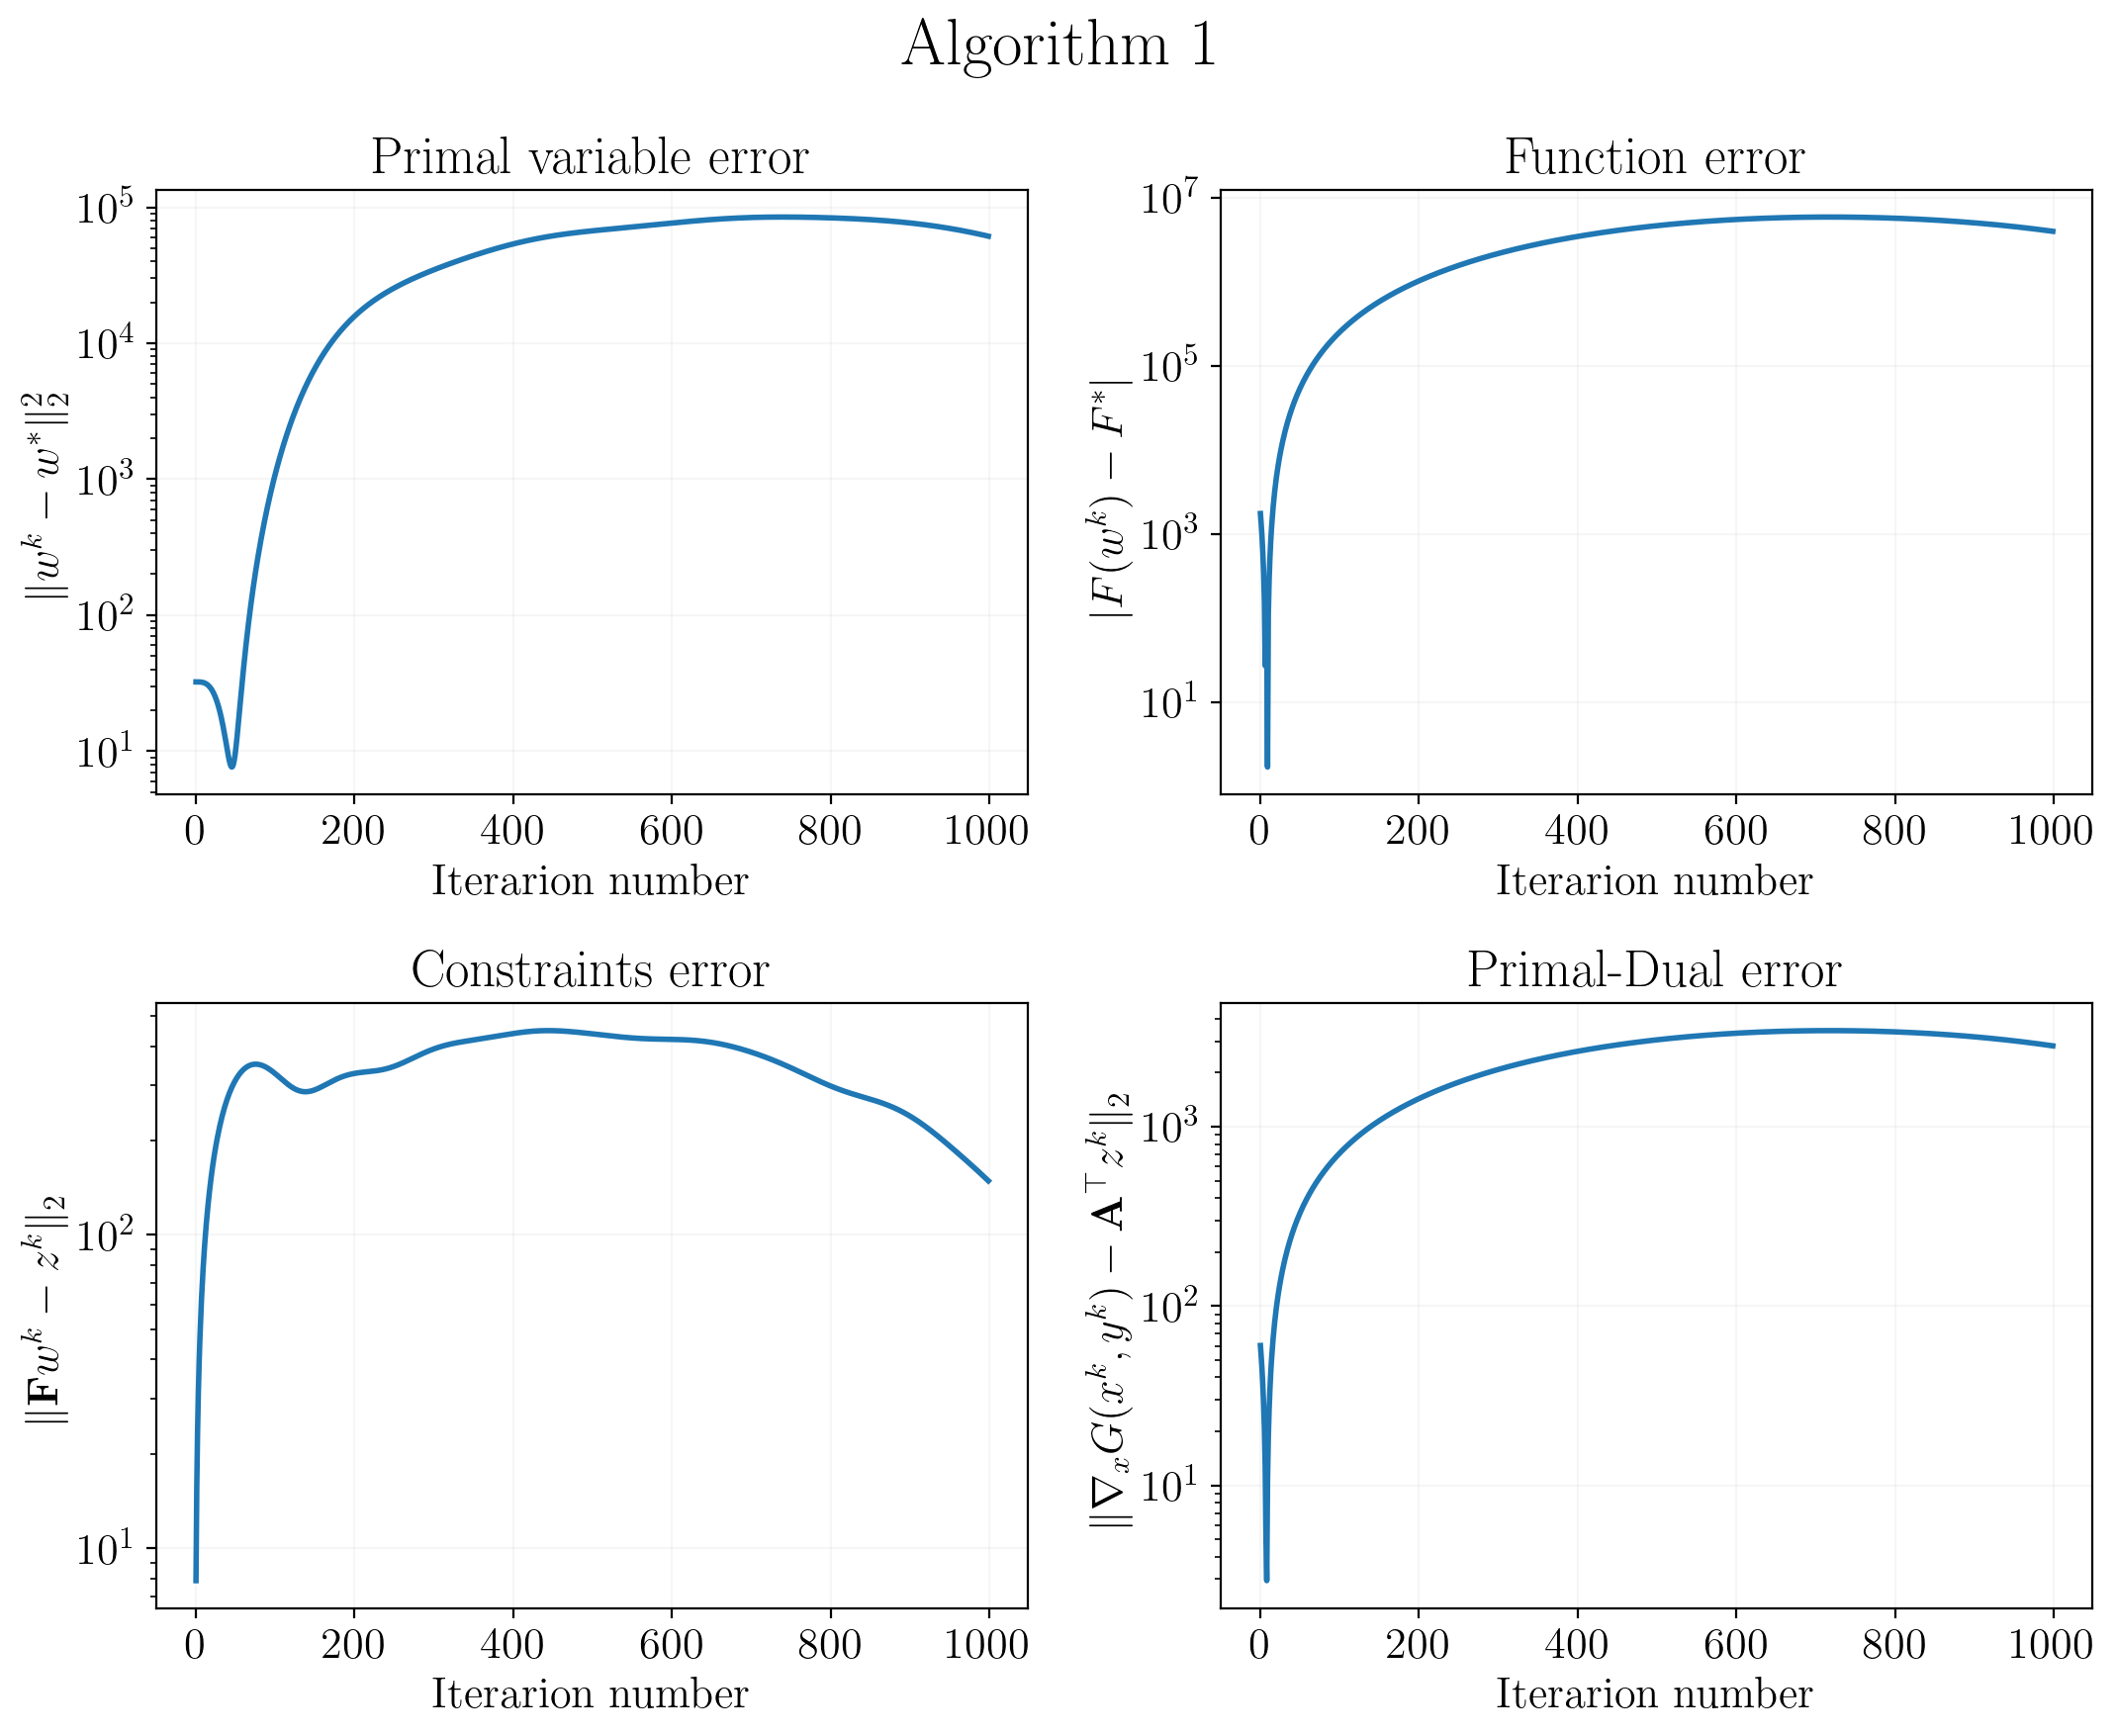

In [33]:
title = 'Algorithm 1'
fig, ax = plt.subplots(2, 2, figsize=(11, 9))

ax[0][0].plot(x_err)
ax[0][0].set_yscale('log')
ax[0][0].set_xlabel("Iterarion number")
ax[0][0].set_ylabel(r"$\| w^k - w^* \|_2^2$")
ax[0][0].set_title("Primal variable error")

ax[0][1].plot(F_err)
ax[0][1].set_yscale('log')
ax[0][1].set_xlabel("Iterarion number")
ax[0][1].set_ylabel(r"$|F(w^k) - F^*|$")
ax[0][1].set_title("Function error")

ax[1][0].plot(cons_err)
ax[1][0].set_yscale('log')
ax[1][0].set_xlabel("Iterarion number")
ax[1][0].set_ylabel(r"$\| \mathbf{F}w^k  - z^k \|_2$")
ax[1][0].set_title("Constraints error")

ax[1][1].plot(primal_dual_err)
ax[1][1].set_yscale('log')
ax[1][1].set_xlabel("Iterarion number")
ax[1][1].set_ylabel(r"$\| \nabla_x G(x^k, y^k) - \mathbf{A}^\top z^k \|_2 $")
ax[1][1].set_title("Primal-Dual error")

plt.suptitle(title, fontsize=24)
plt.tight_layout()
plt.show()

### Tracking-ADMM

In [6]:
x, x_err, F_err, cons_err = TrackingADMM(num_steps=NUM_STEPS, model=model, params={'c': 1e-6})

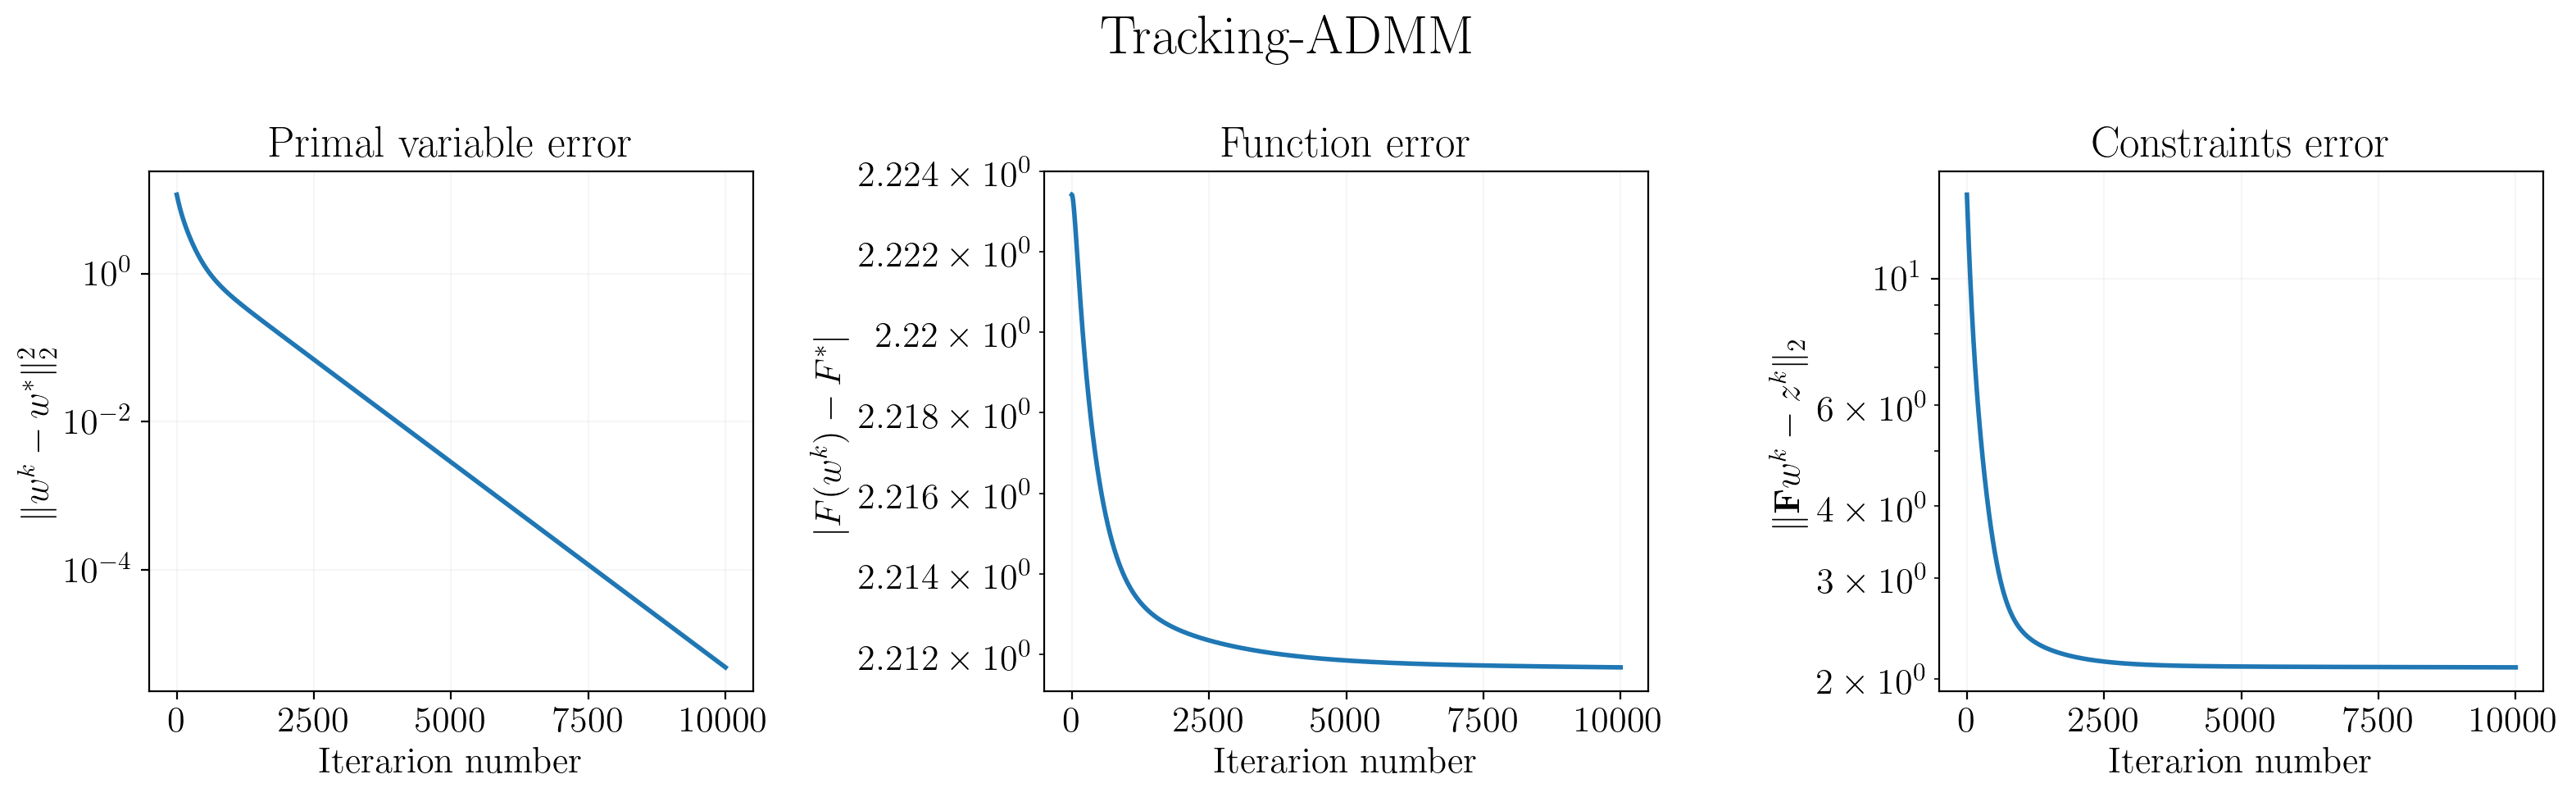

In [7]:
title = 'Tracking-ADMM'
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].plot(x_err)
ax[0].set_yscale('log')
ax[0].set_xlabel("Iterarion number")
ax[0].set_ylabel(r"$\| w^k - w^* \|_2^2$")
ax[0].set_title("Primal variable error")

ax[1].plot(F_err)
ax[1].set_yscale('log')
ax[1].set_xlabel("Iterarion number")
ax[1].set_ylabel(r"$|F(w^k) - F^*|$")
ax[1].set_title("Function error")

ax[2].plot(cons_err)
ax[2].set_yscale('log')
ax[2].set_xlabel("Iterarion number")
ax[2].set_ylabel(r"$\| \mathbf{F}w^k  - z^k \|_2$")
ax[2].set_title("Constraints error")

plt.suptitle(title, fontsize=24)
plt.tight_layout()
plt.show()

### DPMM

In [8]:
x, x_err, F_err, cons_err = DPMM(num_steps=NUM_STEPS, model=model)

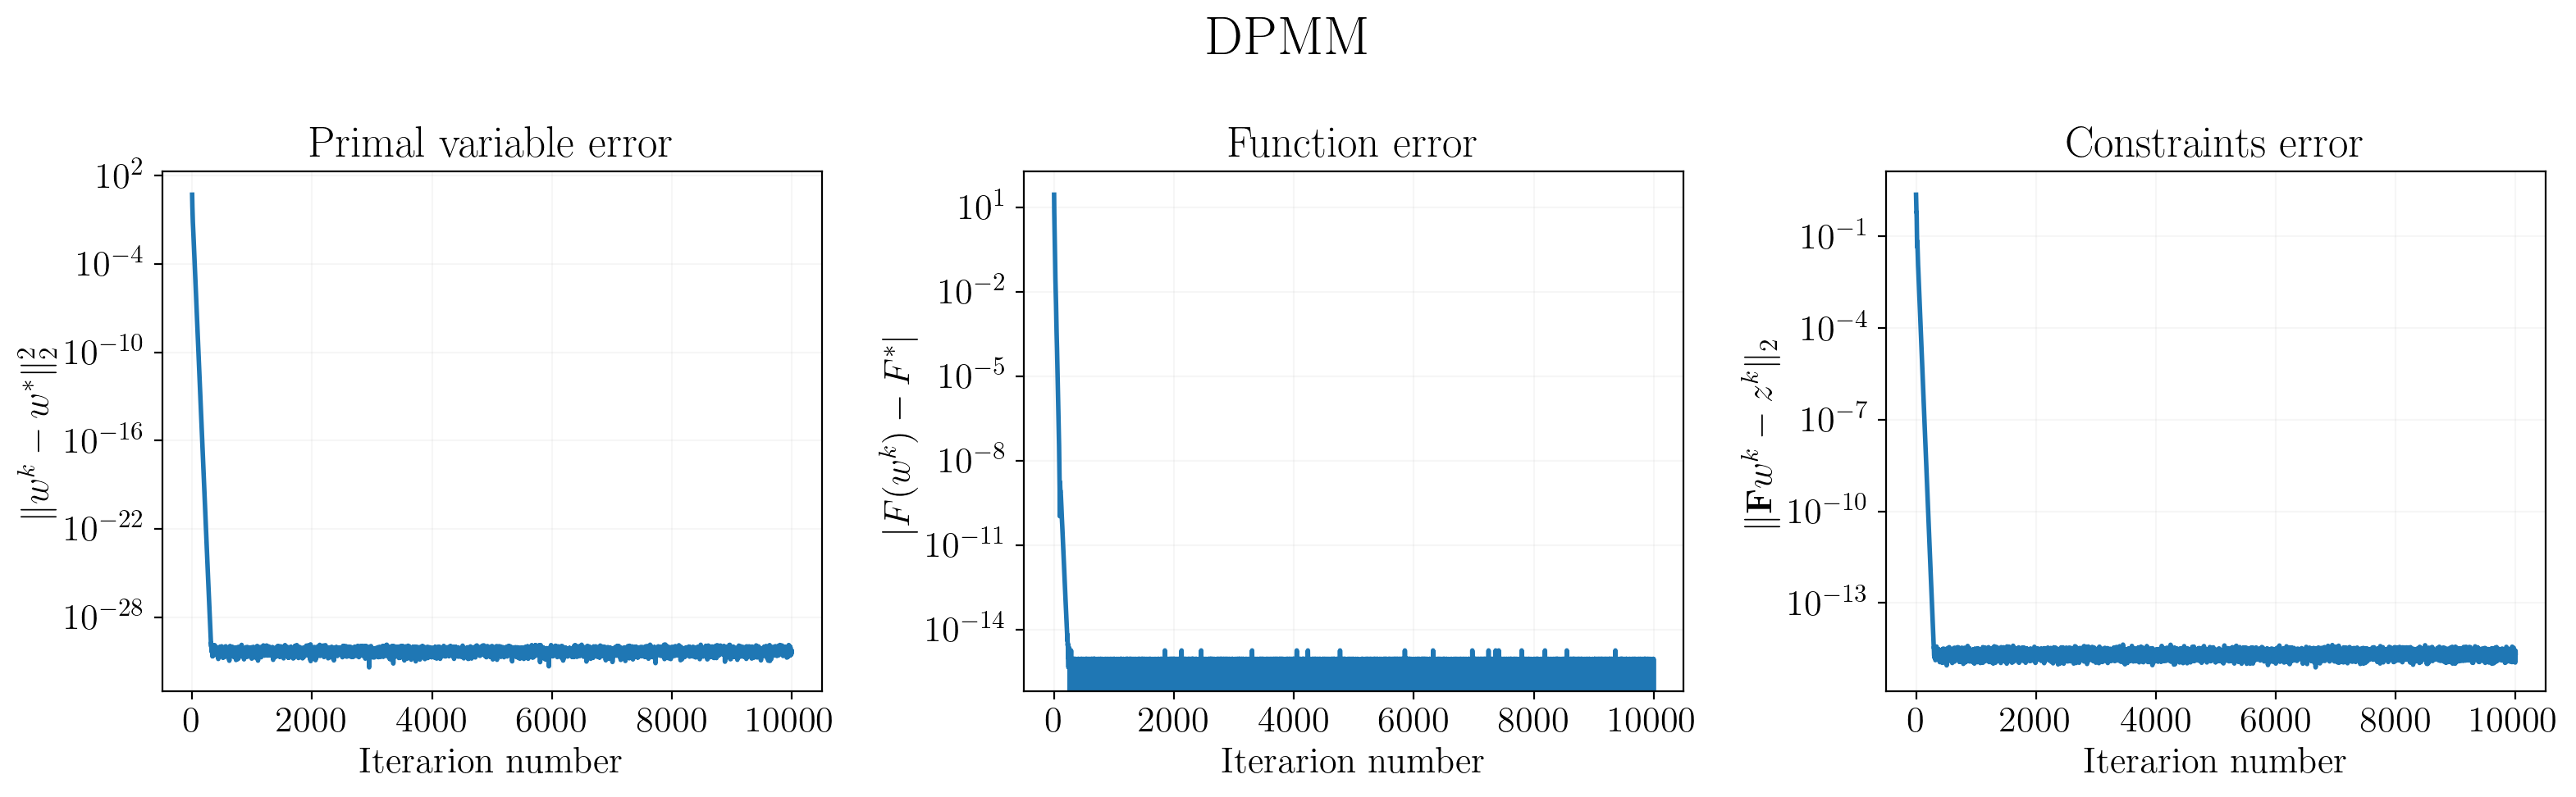

In [9]:
title = 'DPMM'
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].plot(x_err)
ax[0].set_yscale('log')
ax[0].set_xlabel("Iterarion number")
ax[0].set_ylabel(r"$\| w^k - w^* \|_2^2$")
ax[0].set_title("Primal variable error")

ax[1].plot(F_err)
ax[1].set_yscale('log')
ax[1].set_xlabel("Iterarion number")
ax[1].set_ylabel(r"$|F(w^k) - F^*|$")
ax[1].set_title("Function error")

ax[2].plot(cons_err)
ax[2].set_yscale('log')
ax[2].set_xlabel("Iterarion number")
ax[2].set_ylabel(r"$\| \mathbf{F}w^k  - z^k \|_2$")
ax[2].set_title("Constraints error")

plt.suptitle(title, fontsize=24)
plt.tight_layout()
plt.show()

### Comparison

gamma_x 0.499001996007984
gamma_y 10.480562242702703
eta_x 0.6129431873473472
eta_y 17.98941680518424
eta_z 0.001737132467295676
alpha 0.01
beta 0.9997832918578723


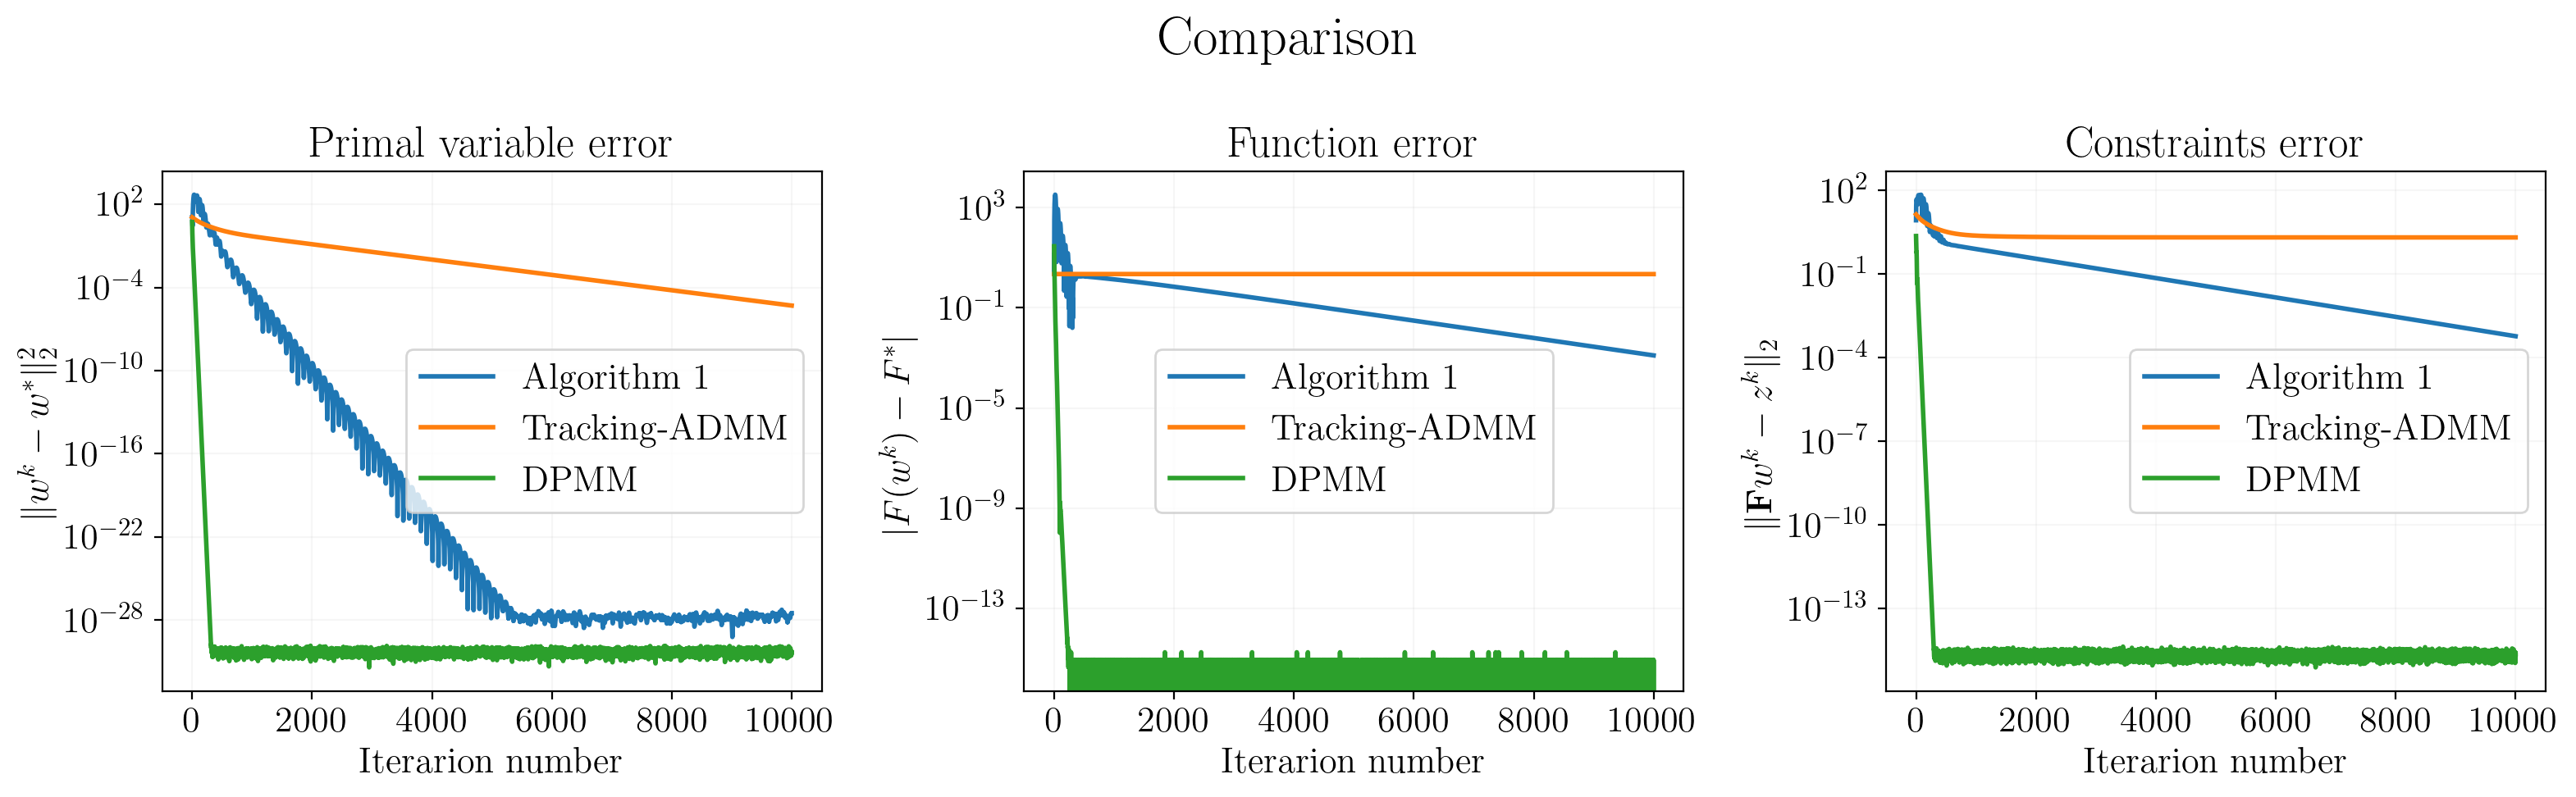

In [10]:
title = "Comparison"
results = {"Algorithm 1": {},
           "Tracking-ADMM": {},
           "DPMM": {}}

name = "Algorithm 1"
_, x_err, F_err, cons_err, _ = algorithm_1(num_steps=NUM_STEPS, model=model)
results[name]['x_err'] = x_err
results[name]['F_err'] = F_err
results[name]['cons_err'] = cons_err

name = "Tracking-ADMM"
_, x_err, F_err, cons_err = TrackingADMM(num_steps=NUM_STEPS, model=model, params={'c': 1e-6})
results[name]['x_err'] = x_err
results[name]['F_err'] = F_err
results[name]['cons_err'] = cons_err

name = "DPMM"
_, x_err, F_err, cons_err = DPMM(num_steps=NUM_STEPS, model=model)
results[name]['x_err'] = x_err
results[name]['F_err'] = F_err
results[name]['cons_err'] = cons_err

fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].plot(results["Algorithm 1"]['x_err'], label="Algorithm 1")
ax[0].plot(results["Tracking-ADMM"]['x_err'], label="Tracking-ADMM")
ax[0].plot(results["DPMM"]['x_err'], label="DPMM")
ax[0].set_yscale('log')
ax[0].set_xlabel("Iterarion number")
ax[0].set_ylabel(r"$\| w^k - w^* \|_2^2$")
ax[0].set_title("Primal variable error")
ax[0].legend()

ax[1].plot(results["Algorithm 1"]['F_err'], label="Algorithm 1")
ax[1].plot(results["Tracking-ADMM"]['F_err'], label="Tracking-ADMM")
ax[1].plot(results["DPMM"]['F_err'], label="DPMM")
ax[1].set_yscale('log')
ax[1].set_xlabel("Iterarion number")
ax[1].set_ylabel(r"$|F(w^k) - F^*|$")
ax[1].set_title("Function error")
ax[1].legend()

ax[2].plot(results["Algorithm 1"]['cons_err'], label="Algorithm 1")
ax[2].plot(results["Tracking-ADMM"]['cons_err'], label="Tracking-ADMM")
ax[2].plot(results["DPMM"]['cons_err'], label="DPMM")
ax[2].set_yscale('log')
ax[2].set_xlabel("Iterarion number")
ax[2].set_ylabel(r"$\| \mathbf{F}w^k  - z^k \|_2$")
ax[2].set_title("Constraints error")
ax[2].legend()

plt.suptitle(title, fontsize=24)
plt.tight_layout()
plt.show()

## Labels are distributed between devices

$$ x_1 = \begin{pmatrix} w_1 \\ z_1 \end{pmatrix}, \quad x_2 = \begin{pmatrix} w_2 \\ z_2 \end{pmatrix}, \quad \ldots, \quad x_n = \begin{pmatrix} w_n \\ z_n \end{pmatrix} $$

$$ f_i(x_i) = f_i(w_i, z_i) = \frac{1}{2}\|z_i - l_i\|_2^2 + \lambda \|w_i\|_2^2, \quad i = 1, \ldots, n $$

$$ A_i = \begin{pmatrix} \mathbf{F}_i & \mathbf{C}_i \end{pmatrix}, \qquad \mathbf{C}_i = \begin{pmatrix} \mathbf{O}_{\mathrm{dim}(z_i)} \\ \vdots \\ -\mathbf{I}_{\mathrm{dim}(z_i)} \\ \vdots \\ \mathbf{O}_{\mathrm{dim}(z_i)} \end{pmatrix}, \quad i = 1, \ldots, n $$

In [11]:
#np.random.seed(307)
#model = VFL(num_nodes, title='mushrooms', train_size=train_size, graph=graph, edge_prob=0.5, gossip=False,
#            labels_distribution=True)

In [12]:
np.random.seed(307)
model = VFL(NUM_NODES, title=TITLE, graph=graph, edge_prob=0.5, gossip=False, labels_distribution=True)

### Algorithm 1

In [13]:
x, x_err, F_err, cons_err, primal_dual_err = algorithm_1(num_steps=NUM_STEPS, model=model)

gamma_x 0.499001996007984
gamma_y 10.588692819752136
eta_x 0.6097679971619994
eta_y 18.083091481365678
eta_z 0.0017281337116611174
alpha 0.01
beta 0.9997844144571281


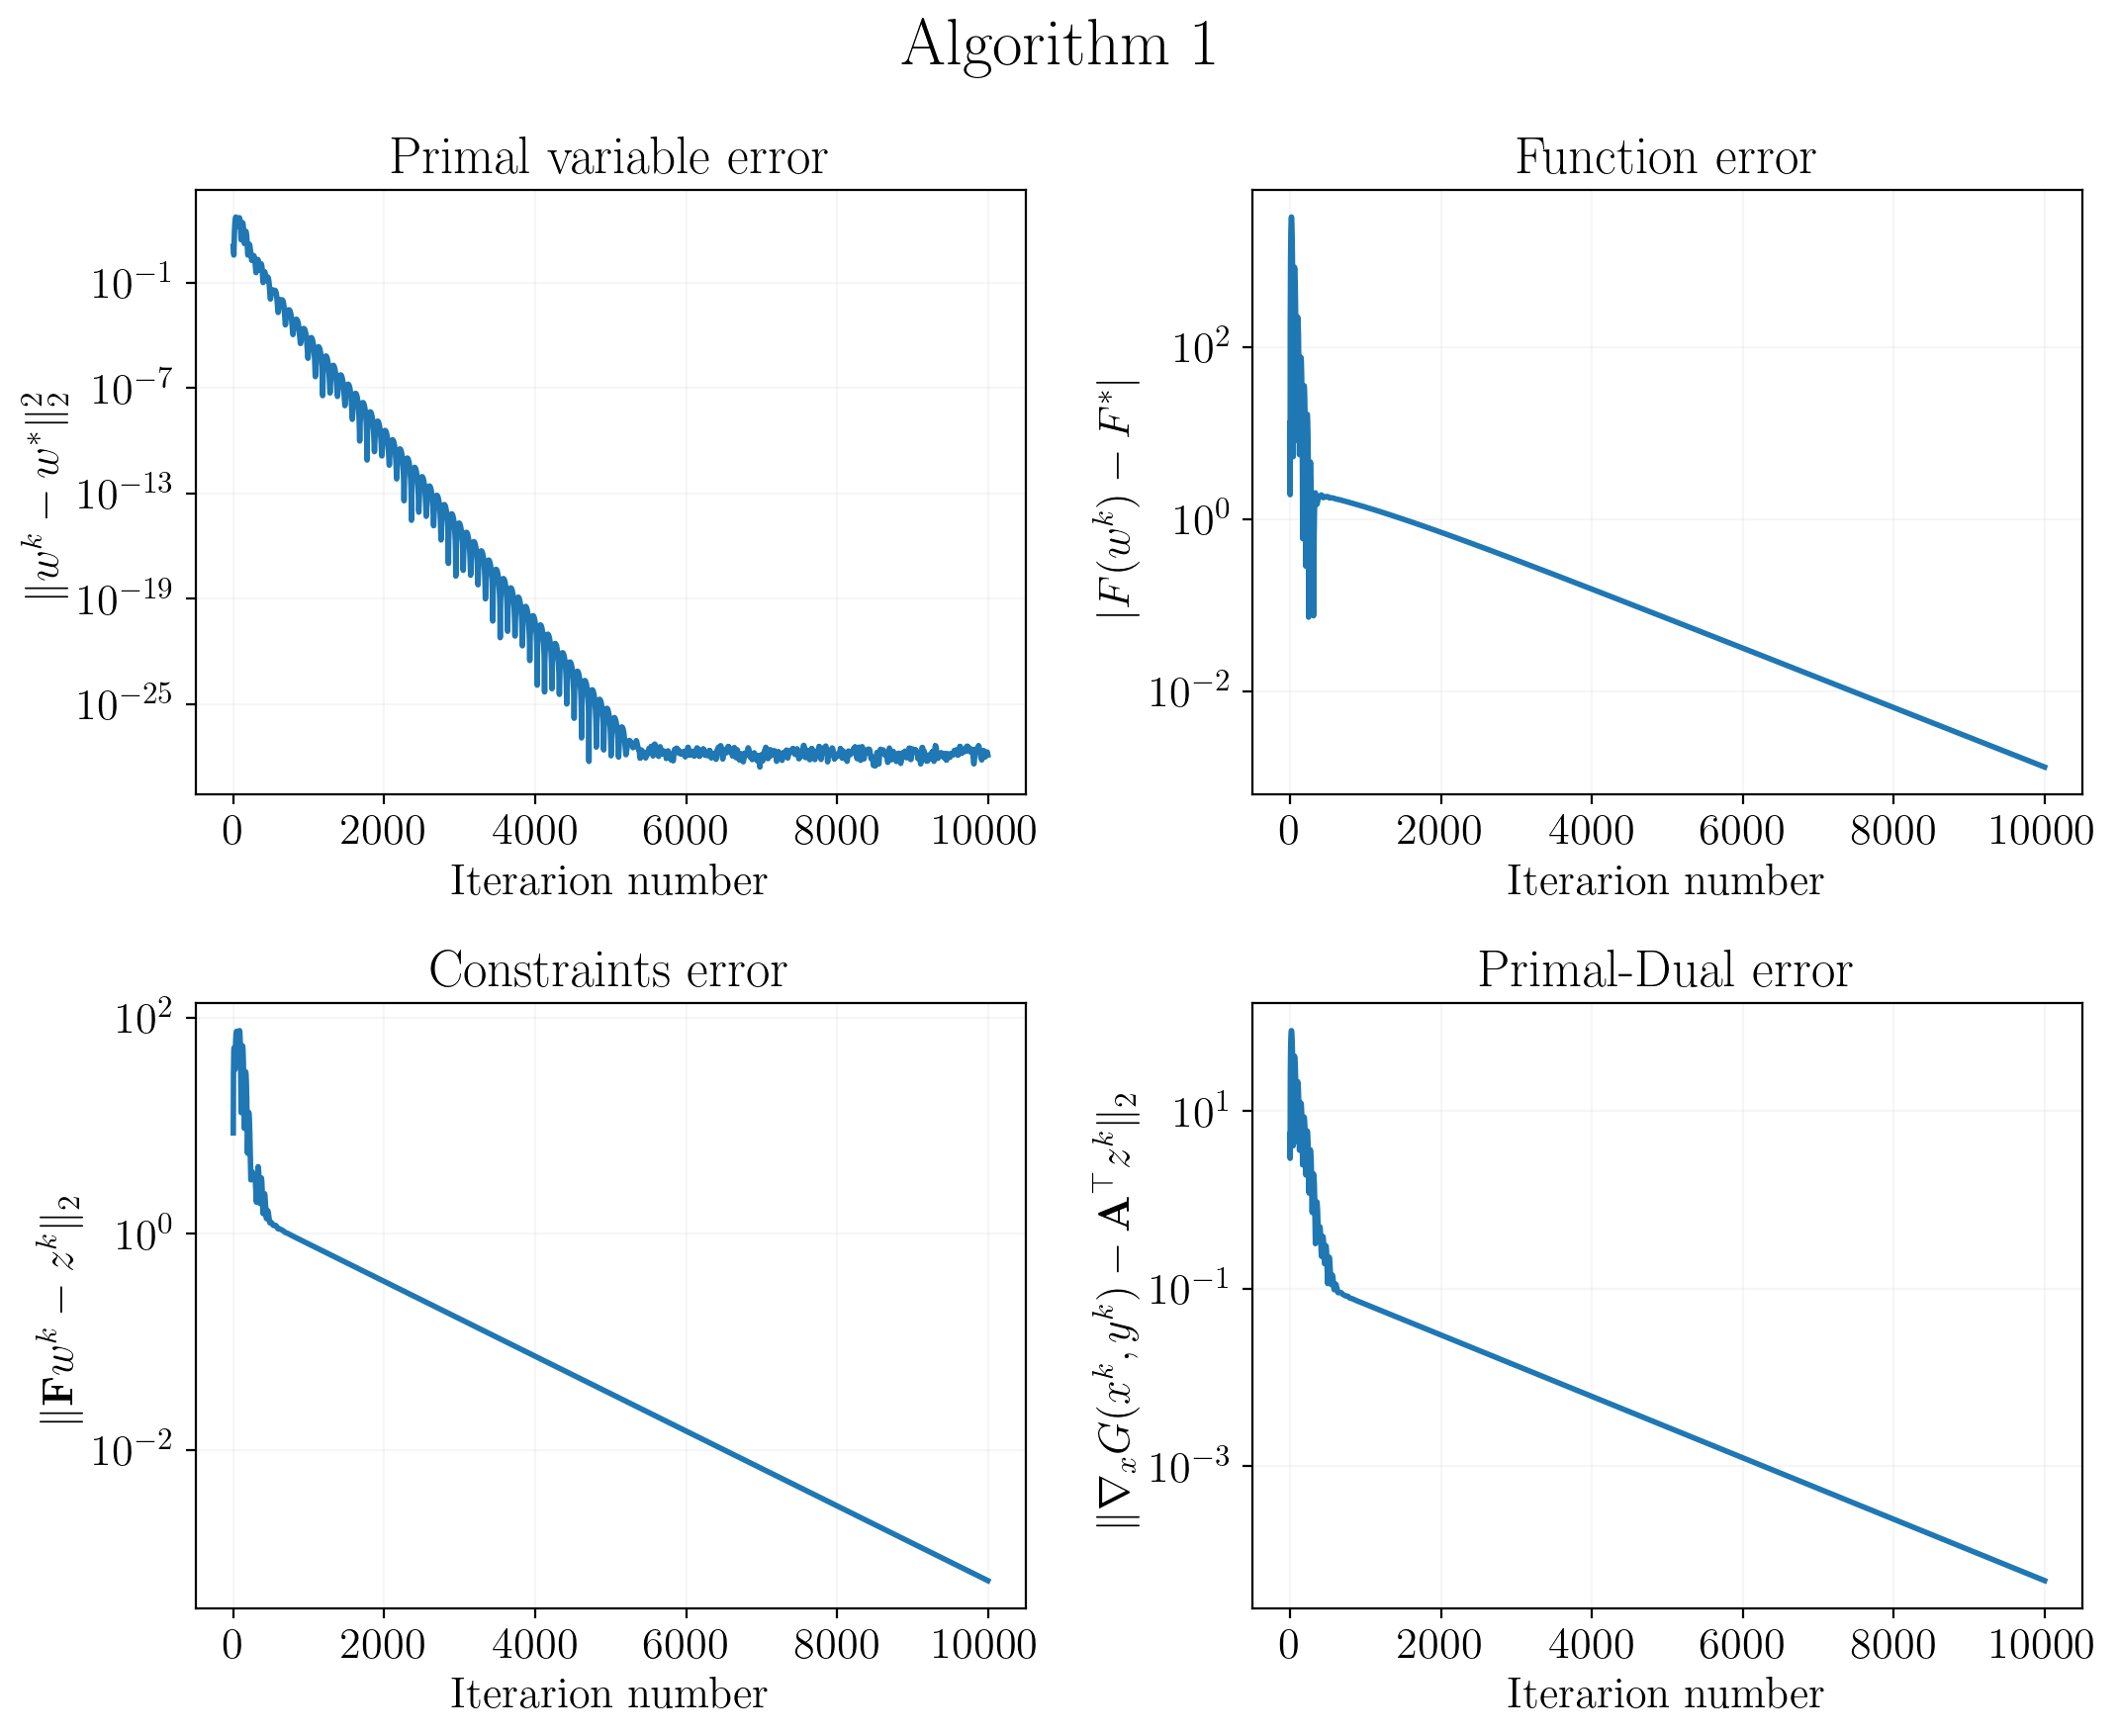

In [14]:
title = 'Algorithm 1'
fig, ax = plt.subplots(2, 2, figsize=(11, 9))

ax[0][0].plot(x_err)
ax[0][0].set_yscale('log')
ax[0][0].set_xlabel("Iterarion number")
ax[0][0].set_ylabel(r"$\| w^k - w^* \|_2^2$")
ax[0][0].set_title("Primal variable error")

ax[0][1].plot(F_err)
ax[0][1].set_yscale('log')
ax[0][1].set_xlabel("Iterarion number")
ax[0][1].set_ylabel(r"$|F(w^k) - F^*|$")
ax[0][1].set_title("Function error")

ax[1][0].plot(cons_err)
ax[1][0].set_yscale('log')
ax[1][0].set_xlabel("Iterarion number")
ax[1][0].set_ylabel(r"$\| \mathbf{F}w^k  - z^k \|_2$")
ax[1][0].set_title("Constraints error")

ax[1][1].plot(primal_dual_err)
ax[1][1].set_yscale('log')
ax[1][1].set_xlabel("Iterarion number")
ax[1][1].set_ylabel(r"$\| \nabla_x G(x^k, y^k) - \mathbf{A}^\top z^k \|_2 $")
ax[1][1].set_title("Primal-Dual error")

plt.suptitle(title, fontsize=24)
plt.tight_layout()
plt.show()

### Tracking-ADMM

In [15]:
x, x_err, F_err, cons_err = TrackingADMM(num_steps=NUM_STEPS, model=model, params={'c': 1e-6})

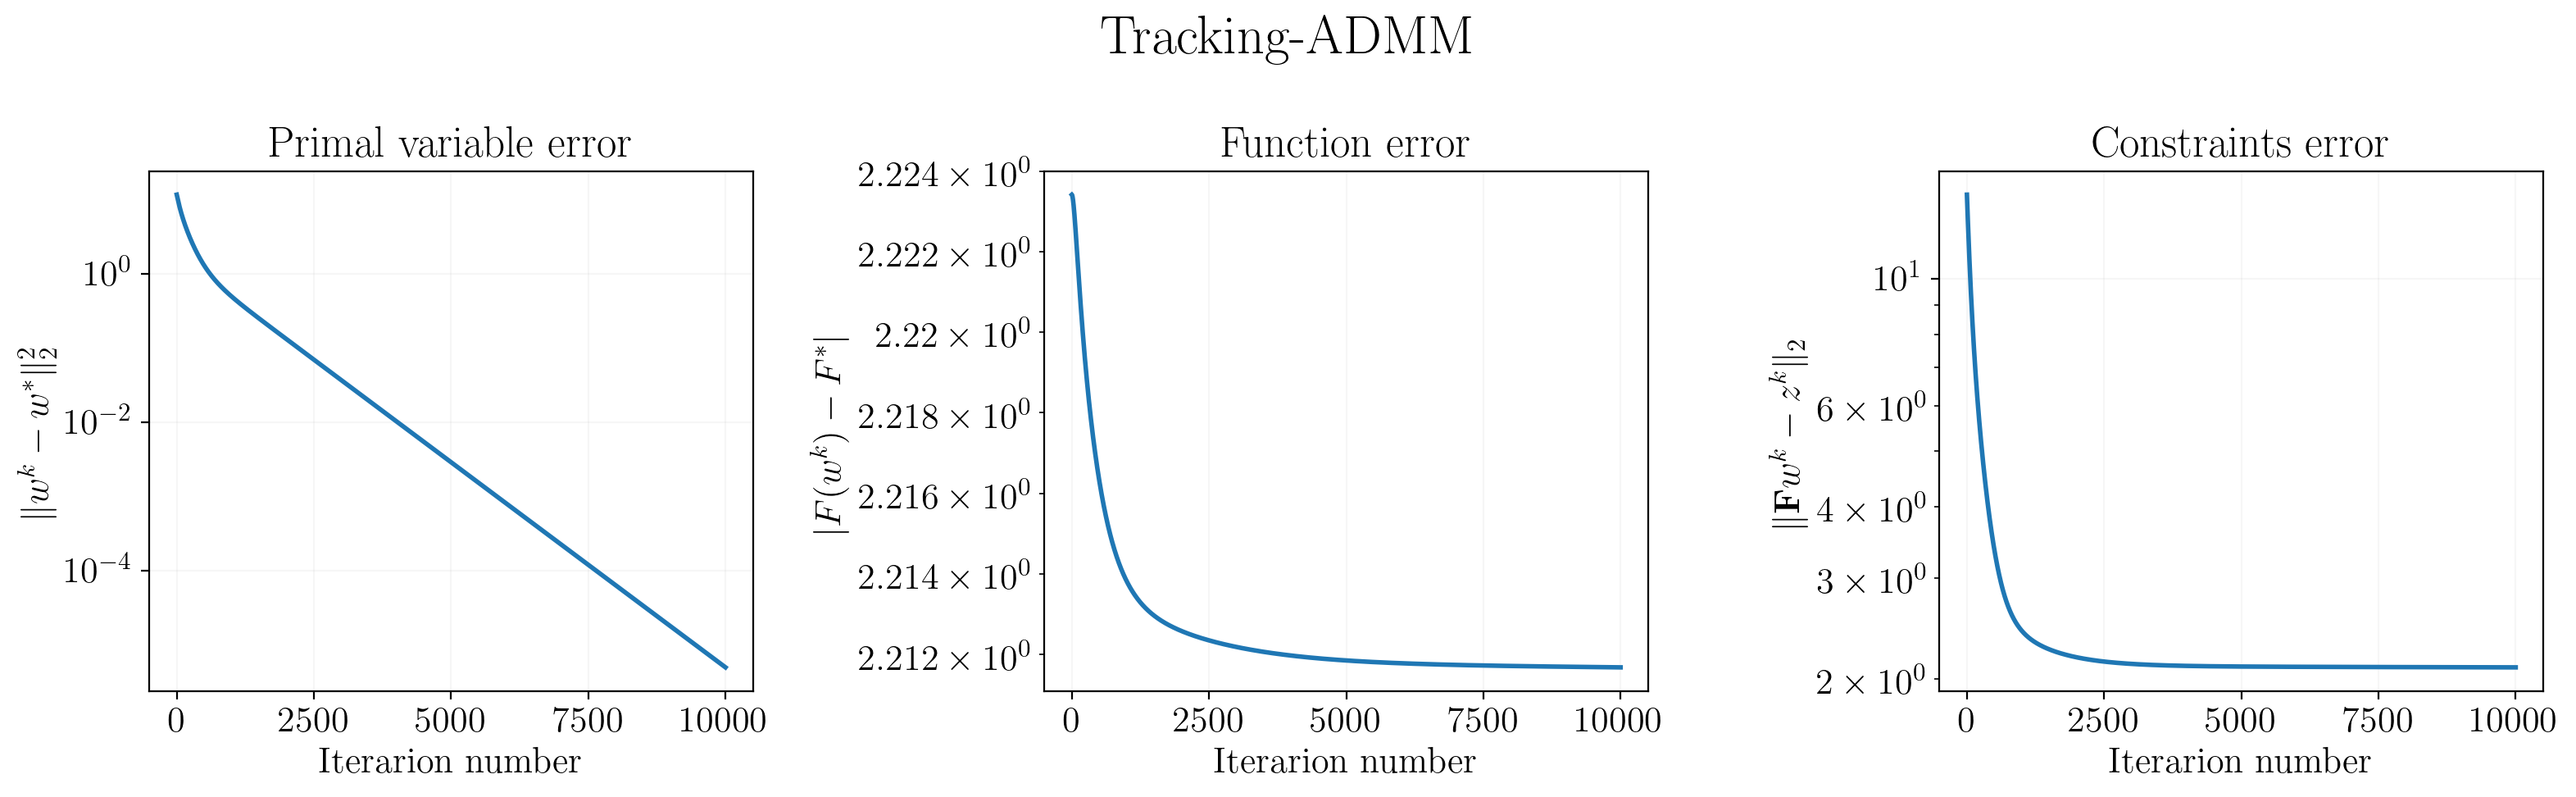

In [16]:
title = 'Tracking-ADMM'
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].plot(x_err)
ax[0].set_yscale('log')
ax[0].set_xlabel("Iterarion number")
ax[0].set_ylabel(r"$\| w^k - w^* \|_2^2$")
ax[0].set_title("Primal variable error")

ax[1].plot(F_err)
ax[1].set_yscale('log')
ax[1].set_xlabel("Iterarion number")
ax[1].set_ylabel(r"$|F(w^k) - F^*|$")
ax[1].set_title("Function error")

ax[2].plot(cons_err)
ax[2].set_yscale('log')
ax[2].set_xlabel("Iterarion number")
ax[2].set_ylabel(r"$\| \mathbf{F}w^k  - z^k \|_2$")
ax[2].set_title("Constraints error")

plt.suptitle(title, fontsize=24)
plt.tight_layout()
plt.show()

### DPMM

In [17]:
x, x_err, F_err, cons_err = DPMM(num_steps=NUM_STEPS, model=model)

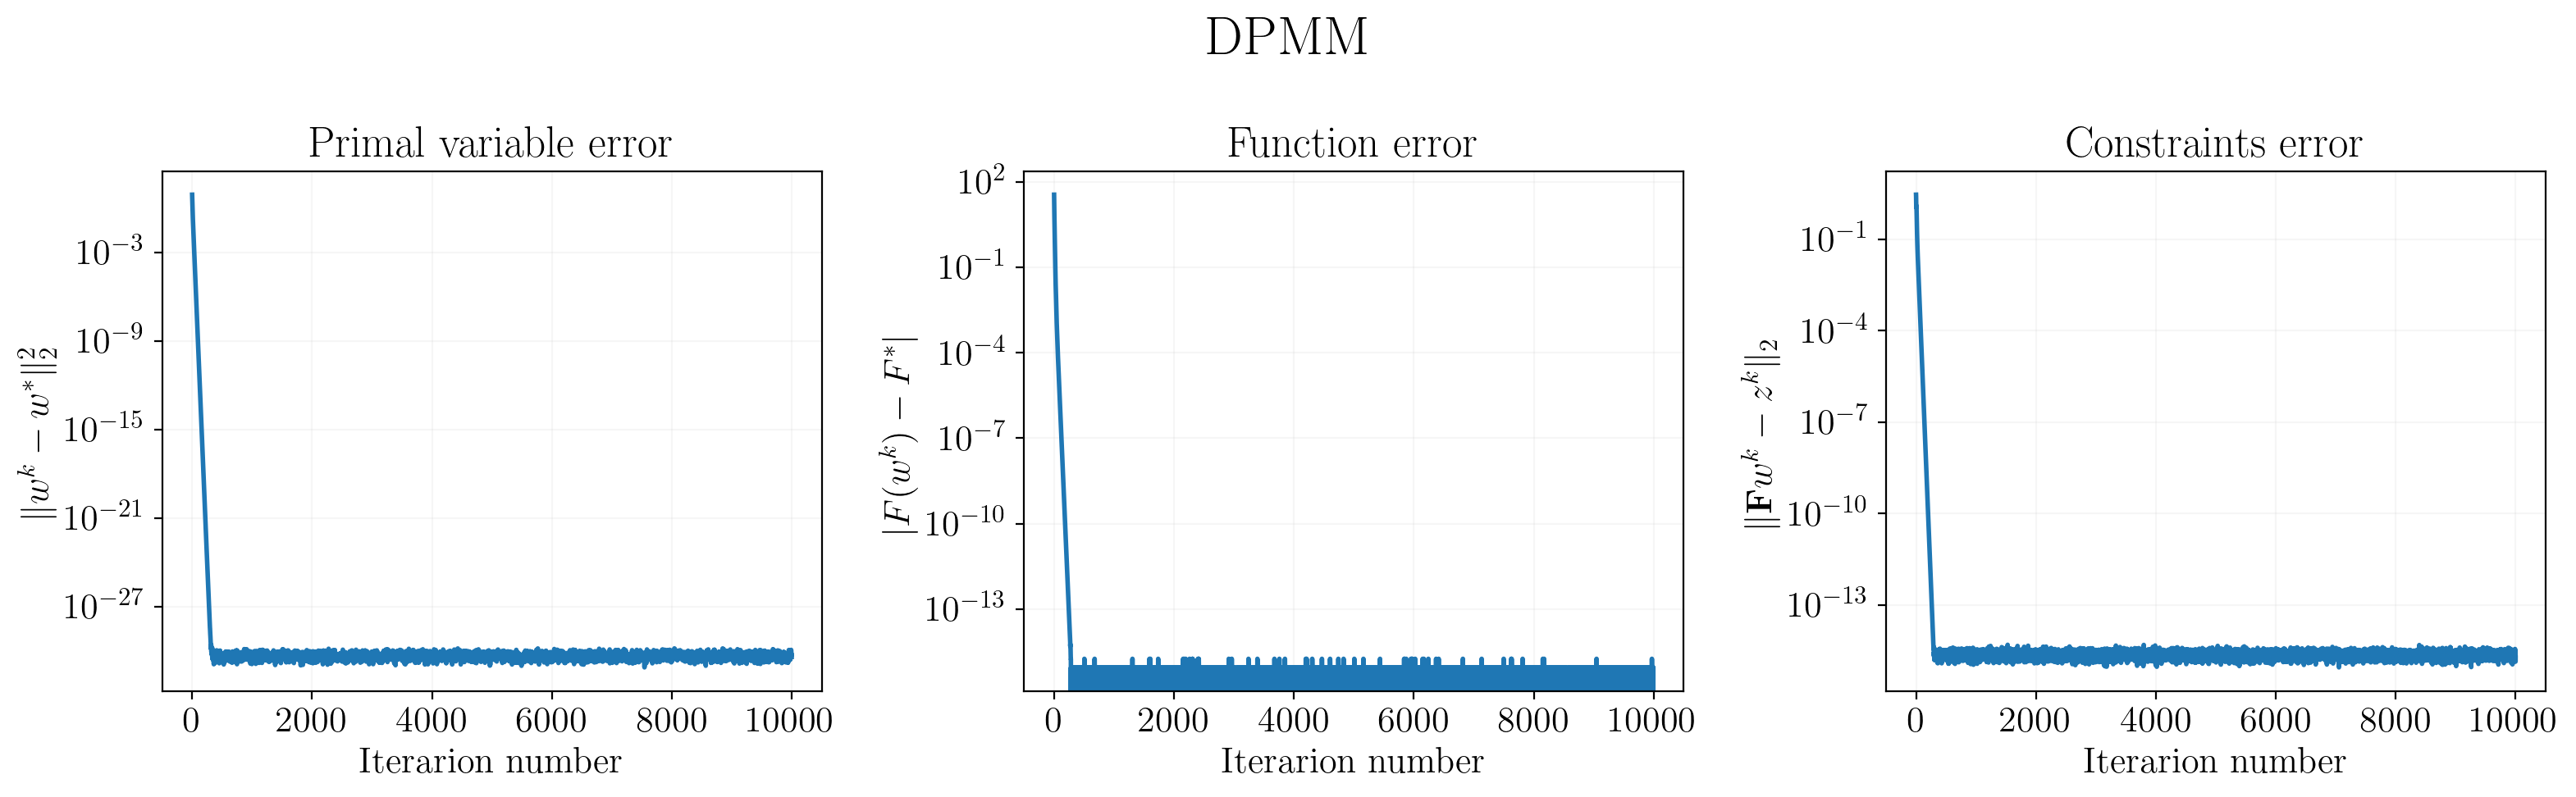

In [18]:
title = 'DPMM'
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].plot(x_err)
ax[0].set_yscale('log')
ax[0].set_xlabel("Iterarion number")
ax[0].set_ylabel(r"$\| w^k - w^* \|_2^2$")
ax[0].set_title("Primal variable error")

ax[1].plot(F_err)
ax[1].set_yscale('log')
ax[1].set_xlabel("Iterarion number")
ax[1].set_ylabel(r"$|F(w^k) - F^*|$")
ax[1].set_title("Function error")

ax[2].plot(cons_err)
ax[2].set_yscale('log')
ax[2].set_xlabel("Iterarion number")
ax[2].set_ylabel(r"$\| \mathbf{F}w^k  - z^k \|_2$")
ax[2].set_title("Constraints error")

plt.suptitle(title, fontsize=24)
plt.tight_layout()
plt.show()

### Comparison

gamma_x 0.499001996007984
gamma_y 10.588692819752136
eta_x 0.6097679971619994
eta_y 18.083091481365678
eta_z 0.0017281337116611174
alpha 0.01
beta 0.9997844144571281


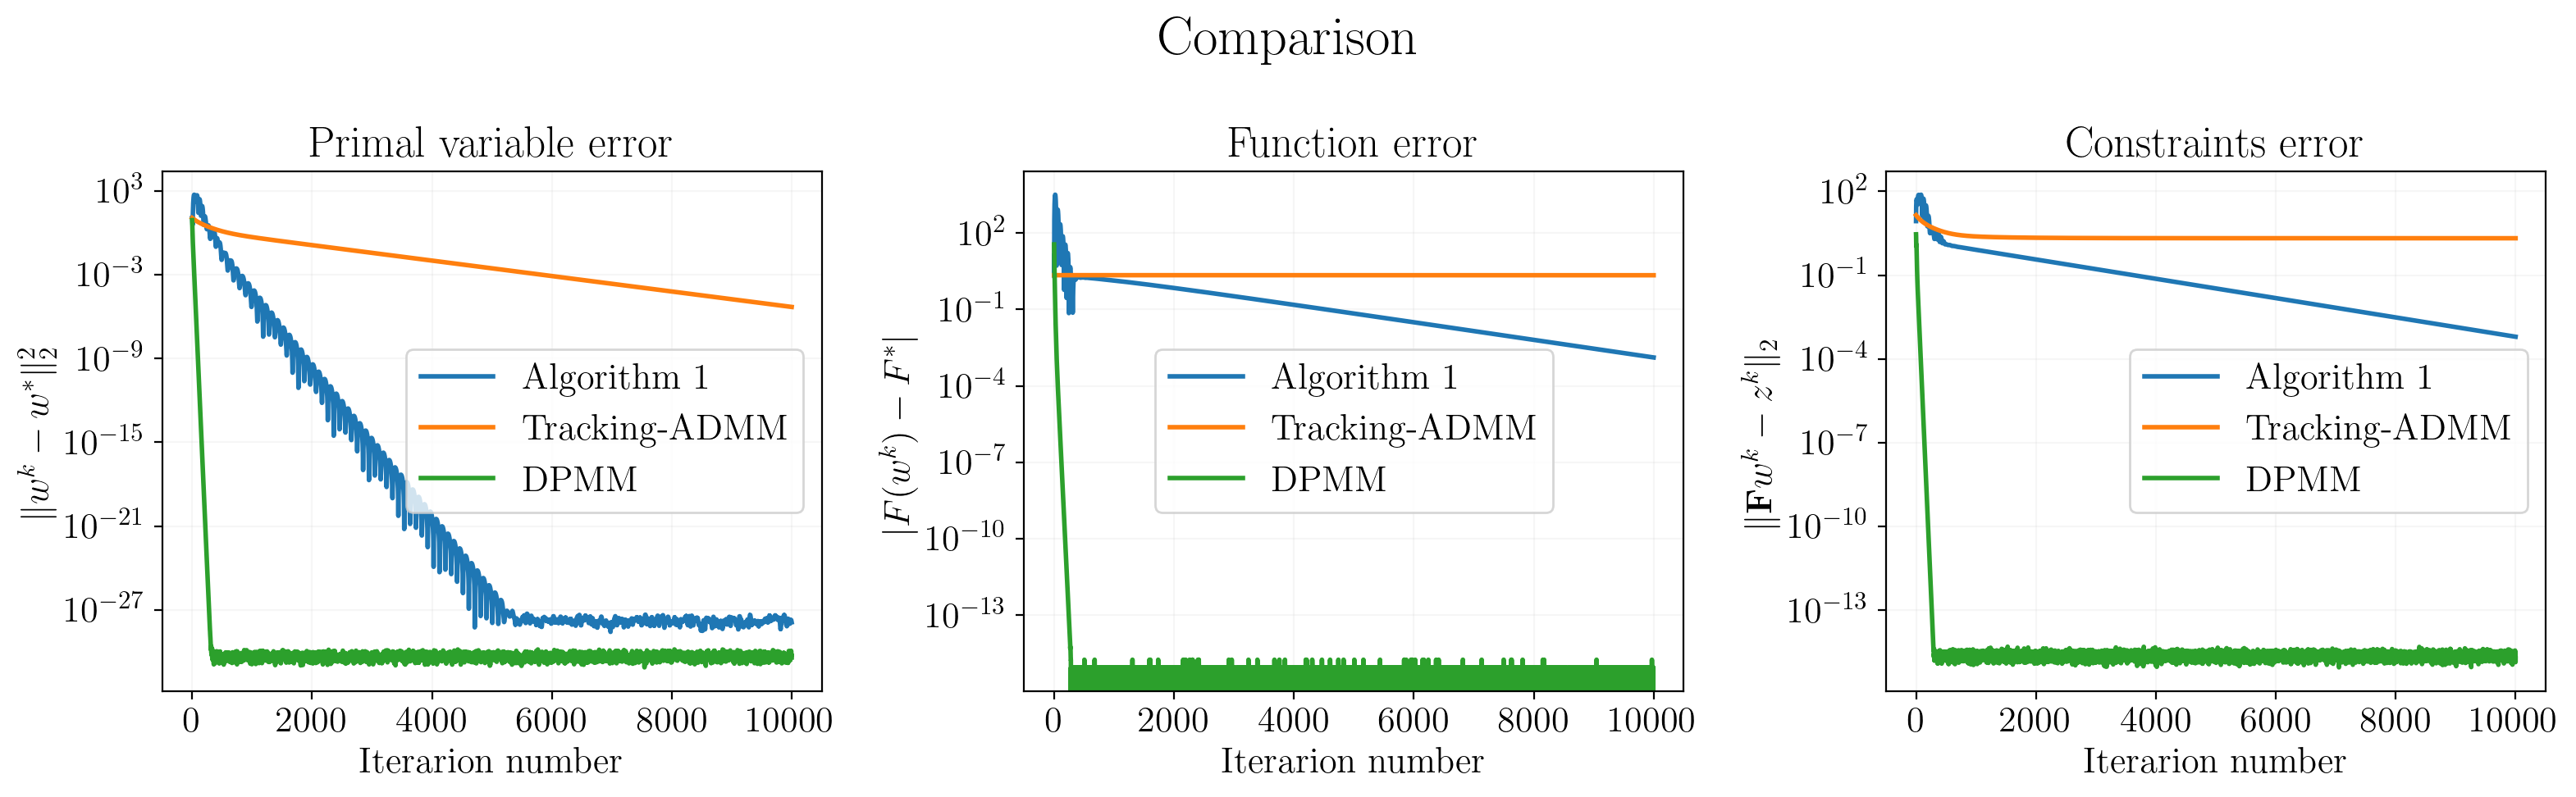

In [19]:
title = "Comparison"
results = {"Algorithm 1": {},
           "Tracking-ADMM": {},
           "DPMM": {}}

name = "Algorithm 1"
_, x_err, F_err, cons_err, _ = algorithm_1(num_steps=NUM_STEPS, model=model)
results[name]['x_err'] = x_err
results[name]['F_err'] = F_err
results[name]['cons_err'] = cons_err

name = "Tracking-ADMM"
_, x_err, F_err, cons_err = TrackingADMM(num_steps=NUM_STEPS, model=model, params={'c': 1e-6})
results[name]['x_err'] = x_err
results[name]['F_err'] = F_err
results[name]['cons_err'] = cons_err

name = "DPMM"
_, x_err, F_err, cons_err = DPMM(num_steps=NUM_STEPS, model=model)
results[name]['x_err'] = x_err
results[name]['F_err'] = F_err
results[name]['cons_err'] = cons_err

fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].plot(results["Algorithm 1"]['x_err'], label="Algorithm 1")
ax[0].plot(results["Tracking-ADMM"]['x_err'], label="Tracking-ADMM")
ax[0].plot(results["DPMM"]['x_err'], label="DPMM")
ax[0].set_yscale('log')
ax[0].set_xlabel("Iterarion number")
ax[0].set_ylabel(r"$\| w^k - w^* \|_2^2$")
ax[0].set_title("Primal variable error")
ax[0].legend()

ax[1].plot(results["Algorithm 1"]['F_err'], label="Algorithm 1")
ax[1].plot(results["Tracking-ADMM"]['F_err'], label="Tracking-ADMM")
ax[1].plot(results["DPMM"]['F_err'], label="DPMM")
ax[1].set_yscale('log')
ax[1].set_xlabel("Iterarion number")
ax[1].set_ylabel(r"$|F(w^k) - F^*|$")
ax[1].set_title("Function error")
ax[1].legend()

ax[2].plot(results["Algorithm 1"]['cons_err'], label="Algorithm 1")
ax[2].plot(results["Tracking-ADMM"]['cons_err'], label="Tracking-ADMM")
ax[2].plot(results["DPMM"]['cons_err'], label="DPMM")
ax[2].set_yscale('log')
ax[2].set_xlabel("Iterarion number")
ax[2].set_ylabel(r"$\| \mathbf{F}w^k  - z^k \|_2$")
ax[2].set_title("Constraints error")
ax[2].legend()

plt.suptitle(title, fontsize=24)
plt.tight_layout()
plt.show()